# Cellular automaton 

## Test file for experiments with many percolation threshold

##### Colin Decourt - Bordeaux INP ENSEIRB-MATMECA
Engineering student in artificial intelligence


###### Import

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import datetime
import cv2 as cv
from tqdm import tqdm
import seaborn as sb
%matplotlib inline

##### Utils functions

In [9]:
def create_gif(filenames, duration, name):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave('./test_data/'+name+output_file, images, duration=duration)

In [10]:
def get_neighbours_indices(forest, cell, valid_cells):
    '''
    Function which get all the valid neighbours of a given cell
    :forest: the forest grid
    :cell: cell's neighbours
    :valid_cells: all the valid coordinates of the forest grid
    '''
    X = [-1, -1, 0, 1, 1, 1, 0, -1]
    Y = [0, 1, 1, 1, 0, -1, -1, -1]
    neighbours_list = []
    
    for k in range(len(X)):
        temp_cell = (cell[0] + X[k], cell[1] + Y[k])
        if temp_cell in valid_cells:
            neighbours_list.append(temp_cell)
    return neighbours_list
            

In [11]:
def valid_cells(forest):
    '''
    Function which get all the coordinates of the grid
    :forest: the forest grid
    '''
    valid_cells = []
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            valid_cells.append((i,j))
    return valid_cells

##### Parameters

In [12]:
cells = {'empty':0, 'tree':1, 'fire': 2, 'ash': 3}

grid_size = (50, 50)

# Display parameters
pallette = np.array( [[153, 102, 0],# empty
                      [0, 51, 8],  # tree1
                      [0, 153, 25],  # tree2
                      [0, 230, 0], # tree3
                      [149, 255, 128], # tree4
                      [230, 115, 0],   # fire
                      [158, 158, 158] # ash
                      ])

In [94]:
def generate_forest(grid_size, density):
    grid = np.random.choice(3, grid_size[0]*grid_size[0] , p = [1-density, density, 0]).reshape(grid_size)
    valid = valid_cells(grid)
    tree=0
    fire = 0
    grid[int(grid_size[0]/2), int(grid_size[1]/2)] = cells['fire']
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i,j] == 1:
                tree +=1
            if grid[i,j] == 2:
                fire += 1
    initial_forest = {'fire': fire, 'tree':tree}
    return grid, initial_forest

##### Transition functions

Transition rules : 

- An empty cell stay empty
- A ash cell stay ash
- A fire cell become ash
- A tree cell :
    - Become fire if one of them neighbour is in fire
    - Stay tree otherwise

In [41]:
def may_burn(forest, cell, cell_type, state):
    to_burn = []
    no_burn = []

    neigh_list = get_neighbours_indices(forest, cell, EXIST_CELLS)
    for neigh_cell in neigh_list:
        if forest[neigh_cell] == cells['fire']:
            to_burn.append(neigh_cell)       
        else:
            no_burn.append(neigh_cell)
    if to_burn == []:
        return cells[cell_type], state
    else:
        state[cell_type]-=1
        state['fire'] += 1
        return cells['fire'], state

In [53]:
def transition_general(forest, cell, state):
    '''
    Function which return the future state of a given cell
    :forest: the forest grid
    :cell: cell's future state wanted
    :state: state of the country at current step
    '''
    try:
        if forest[cell] == cells['empty']:
            return cells['empty'], state

        if forest[cell] == cells['ash']:
            return cells['ash'], state

        if forest[cell] == cells['tree']:
            return may_burn(forest, cell, 'tree', state)

        if forest[cell] == cells['fire']:
            state['fire']-=1
            return cells['ash'], state
        
    except:
        print('Unknown cell type. Abort.')
    
    

##### Fire propagation

In [43]:
def step(forest, is_fire, state):
    '''
    Function which perfom one propagation step
    :forest: the forest grid
    :is_fire: boolean informing the fire state - True : still cell in fire False otherwise
    '''
    nb_fire = 0
    new_forest = forest.copy()
    new_state = state.copy()
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            cell_type, new_state = transition_general(forest, (i,j), new_state)
            new_forest[i,j] = cell_type
            if new_forest[i,j] == cells['fire']:
                nb_fire += 1
    print(nb_fire)
    if nb_fire == 0:
        is_fire = False
    return new_forest, is_fire, new_state

In [44]:
# Reset images
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            os.remove(name)

## Fire forest on random grid

In [ ]:
densities = np.arange(0,1, 0.05)

for i in densities:
    density = {'tree': i}
    forest, initial_state = generate_forest(grid_size, i)
    EXIST_CELLS = valid_cells(forest)
    is_fire = True
    state_list =[]
    state_list.append(initial_state)
    num_step = 0
    plt.figure(figsize=(10,10))
    plt.imshow(forest)
    plt.savefig(str(num_step)+'.png')
    plt.clf()
    while(1):
        print('--- STEP',num_step,'begin ---')
        forest, is_fire, state = step(forest, is_fire, state_list[num_step])
        print('New state:',state)
        state_list.append(state.copy())
        num_step+=1
        plt.figure(figsize=(10,10))
        plt.imshow(forest)
        plt.savefig(str(num_step)+'.png')
        plt.clf()
        if is_fire is False:
            print('Fire is dead...')
            break
    np.save('./test_data/state_list_'+str(i), state_list)
    filenames = []
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                filenames.append(name)
    filenames.sort(key=lambda x: float(x[:-4]))

    create_gif(filenames, duration=0.8, name='./gif/'+str(grid_size))
    # Reset images
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                os.remove(name)

### Data analyse

In [73]:
def get_data(data):
    fire_list = []
    ash_list = []
    tree_list = []
    for i in range(len(data)):
        fire_list.append(data[i]['fire'])
        tree_list.append(data[i]['tree'])
    return tree_list, fire_list, ash_list

In [99]:
def get_burned_trees(tree_list):
    if tree_list == []:
        return 0
    burn_list = (tree_list[0]-tree_list[-1])*100/tree_list[0]
    return burn_list

def get_remain_trees(tree_list):
    if tree_list == []:
        return 0
    remain_list = (tree_list[-1])*100/tree_list[0]
    return remain_list

SyntaxError: invalid syntax (<ipython-input-99-6a38e5b55530>, line 2)

In [75]:
grid0 = get_data(np.load('test_data/state_list_0.0.npy', allow_pickle=True))
grid0_05 = get_data(np.load('test_data/state_list_0.05.npy', allow_pickle=True))
grid0_1 = get_data(np.load('test_data/state_list_0.1.npy', allow_pickle=True))
grid0_15 = get_data(np.load('test_data/state_list_0.15000000000000002.npy', allow_pickle=True))
grid0_2 = get_data(np.load('test_data/state_list_0.2.npy', allow_pickle=True))
grid0_25 = get_data(np.load('test_data/state_list_0.25.npy', allow_pickle=True))
grid0_3 = get_data(np.load('test_data/state_list_0.30000000000000004.npy', allow_pickle=True))
grid0_35 = get_data(np.load('test_data/state_list_0.35000000000000003.npy', allow_pickle=True))
grid0_4 = get_data(np.load('test_data/state_list_0.4.npy', allow_pickle=True))
grid0_45 = get_data(np.load('test_data/state_list_0.45.npy', allow_pickle=True))
grid0_5 = get_data(np.load('test_data/state_list_0.5.npy', allow_pickle=True))
grid0_55 = get_data(np.load('test_data/state_list_0.55.npy', allow_pickle=True))
grid0_6 = get_data(np.load('test_data/state_list_0.6000000000000001.npy', allow_pickle=True))
grid0_65 = get_data(np.load('test_data/state_list_0.65.npy', allow_pickle=True))
grid0_7 = get_data(np.load('test_data/state_list_0.7000000000000001.npy', allow_pickle=True))
grid0_75 = get_data(np.load('test_data/state_list_0.75.npy', allow_pickle=True))
grid0_8 = get_data(np.load('test_data/state_list_0.8.npy', allow_pickle=True))
grid0_85 = get_data(np.load('test_data/state_list_0.8500000000000001.npy', allow_pickle=True))
grid0_9 = get_data(np.load('test_data/state_list_0.9.npy', allow_pickle=True))
grid0_95 = get_data(np.load('test_data/state_list_0.9500000000000001.npy', allow_pickle=True))

In [76]:
tree_per_dens = [grid0, grid0_05, grid0_1, grid0_15,
                grid0_2, grid0_25, grid0_3, grid0_35,
                grid0_4, grid0_45, grid0_5, grid0_55,
                grid0_6, grid0_65, grid0_7, grid0_75,
                grid0_8, grid0_85, grid0_9, grid0_95]

burn_trees = [get_burned_trees(tree_per_dens[i][0]) for i in range(len(tree_per_dens))]
remain_trees = [get_remain_trees(tree_per_dens[i][0]) for i in range(len(tree_per_dens))]

ZeroDivisionError: division by zero

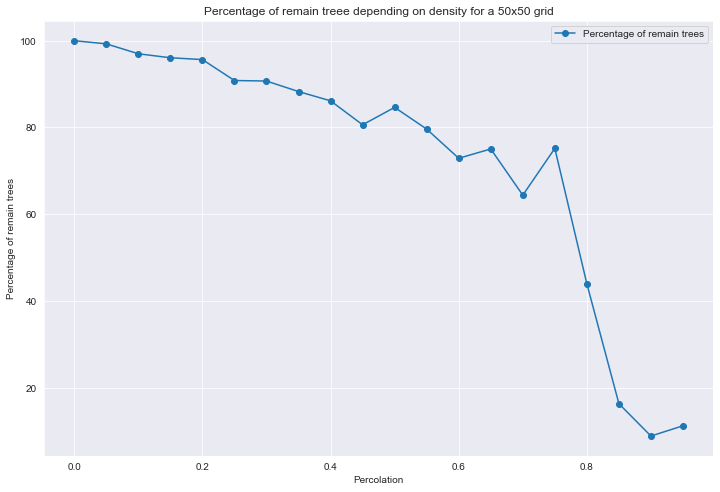

In [77]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(densities, remain_trees, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of remain trees')
plt.title('Percentage of remain treee depending on density for a 50x50 grid')
plt.legend(('Percentage of remain trees',))
plt.savefig('./test_data/real_remain_tree_density.png')
plt.show()

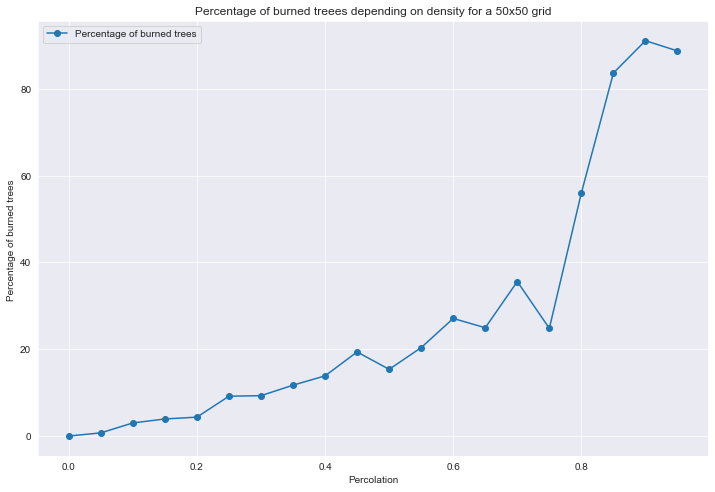

In [78]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(densities, burn_trees, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees ')
plt.title('Percentage of burned treees depending on density for a 50x50 grid')
plt.legend(('Percentage of burned trees',), loc='upper left')
plt.savefig('./test_data/real_burned_tree_density.png')
plt.show()